In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib  # Untuk menyimpan model
import shap   # Untuk interpretasi model
from mlxtend.plotting import plot_decision_regions  # Untuk visualisasi decision boundary

Missing Values:
 SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Statistik Deskriptif:
        SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
count     150.000000    150.000000     150.000000    150.000000
mean        5.843333      3.054000       3.758667      1.198667
std         0.828066      0.433594       1.764420      0.763161
min         4.300000      2.000000       1.000000      0.100000
25%         5.100000      2.800000       1.600000      0.300000
50%         5.800000      3.000000       4.350000      1.300000
75%         6.400000      3.300000       5.100000      1.800000
max         7.900000      4.400000       6.900000      2.500000


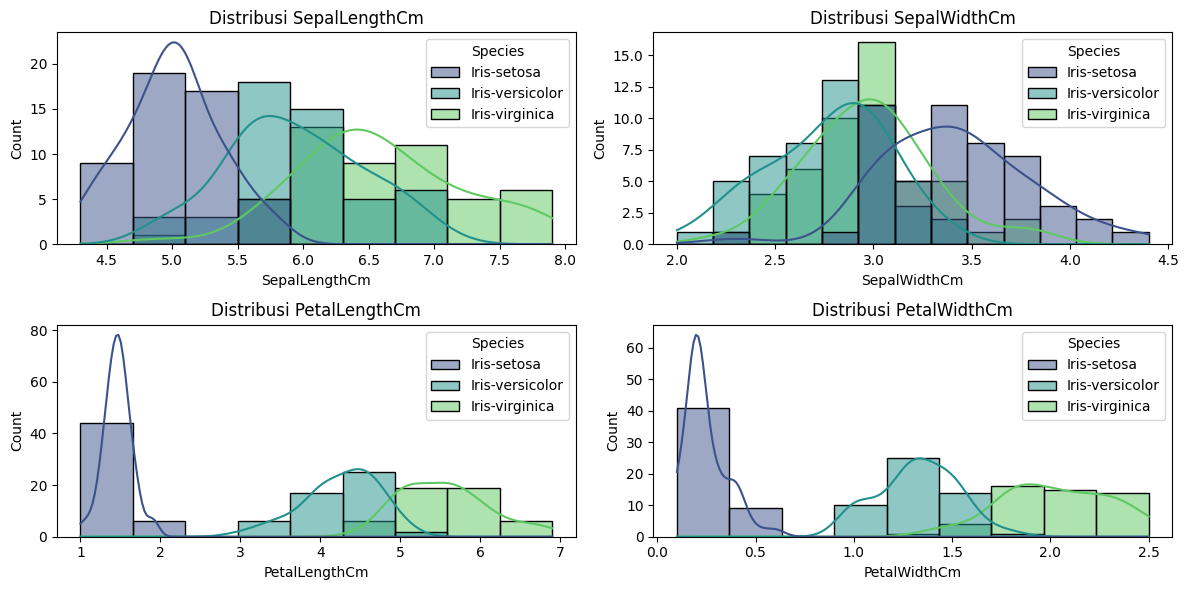

In [5]:
# Load dataset
iris = pd.read_csv('Iris.csv')

# Hapus kolom 'Id' yang tidak diperlukan
iris = iris.drop('Id', axis=1)

# Cek missing values
print("Missing Values:\n", iris.isnull().sum())

# Statistik deskriptif
print("\nStatistik Deskriptif:\n", iris.describe())

# Visualisasi distribusi fitur
plt.figure(figsize=(12, 6))
for i, feature in enumerate(iris.columns[:-1]):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=iris, x=feature, hue='Species', kde=True, palette='viridis')
    plt.title(f'Distribusi {feature}')
plt.tight_layout()
plt.show()

In [6]:
# Encode label 'Species' menjadi numerik
le = LabelEncoder()
iris['Species'] = le.fit_transform(iris['Species'])

# Pisahkan fitur (X) dan target (y)
X = iris.drop('Species', axis=1)
y = iris['Species']

# Bagi data menjadi training (70%) dan testing (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
# Definisikan model Random Forest
rf = RandomForestClassifier(random_state=42)

# Parameter grid untuk tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Lakukan GridSearchCV untuk mencari parameter terbaik
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Model terbaik setelah tuning
best_rf = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# Simpan model ke file (untuk penggunaan di masa depan)
joblib.dump(best_rf, 'best_random_forest_model.pkl')


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


['best_random_forest_model.pkl']


Akurasi Model: 1.0000

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45



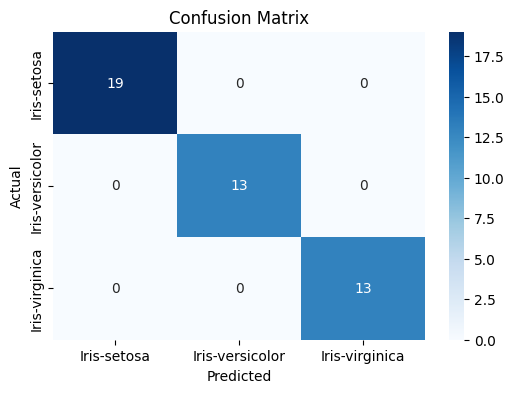

In [8]:
# Prediksi data test
y_pred = best_rf.predict(X_test)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAkurasi Model: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

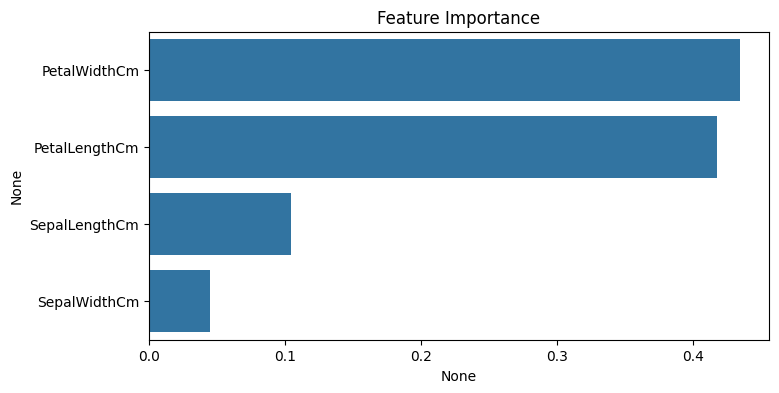

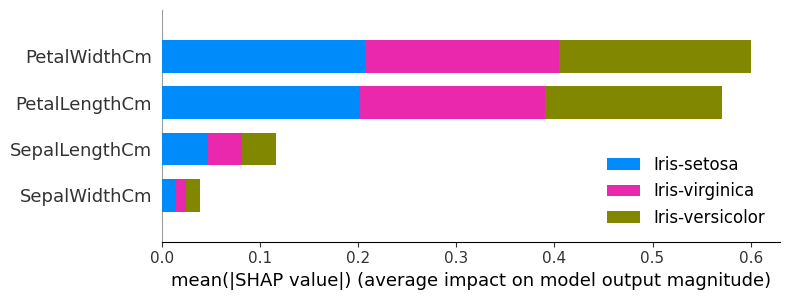

In [9]:
# Feature Importance
feature_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Feature Importance')
plt.show()

# SHAP Values (Interpretasi Lebih Dalam)
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=le.classes_)

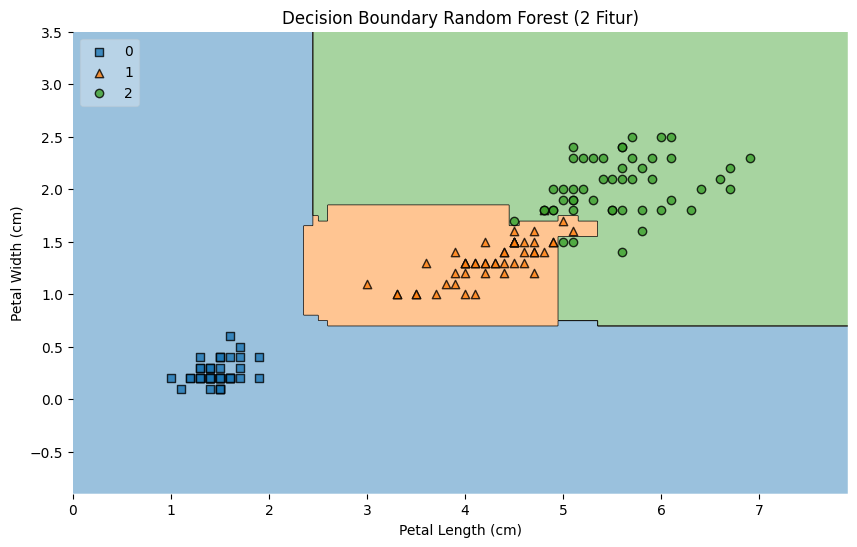

In [10]:
# Ambil 2 fitur terpenting (Petal Length & Petal Width)
X_2d = X[['PetalLengthCm', 'PetalWidthCm']].values
y_2d = y.values

# Latih ulang model hanya dengan 2 fitur
rf_2d = RandomForestClassifier(n_estimators=100, random_state=42)
rf_2d.fit(X_2d, y_2d)

# Plot decision boundary
plt.figure(figsize=(10, 6))
plot_decision_regions(X_2d, y_2d, clf=rf_2d, legend=2)
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Decision Boundary Random Forest (2 Fitur)')
plt.show()

In [11]:
def predict_species(sepal_length, sepal_width, petal_length, petal_width):
    # Load model yang sudah disimpan
    model = joblib.load('best_random_forest_model.pkl')

    # Buat DataFrame dari input
    input_data = pd.DataFrame({
        'SepalLengthCm': [sepal_length],
        'SepalWidthCm': [sepal_width],
        'PetalLengthCm': [petal_length],
        'PetalWidthCm': [petal_width]
    })

    # Prediksi
    pred = model.predict(input_data)[0]
    species = le.inverse_transform([pred])[0]

    print(f"\nPrediksi Spesies: {species}")

# Contoh penggunaan:
predict_species(5.1, 3.5, 1.4, 0.2)  # Harusnya Iris-setosa
predict_species(6.0, 2.7, 5.1, 1.6)  # Harusnya Iris-versicolor
predict_species(7.2, 3.6, 6.1, 2.5)  # Harusnya Iris-virginica


Prediksi Spesies: Iris-setosa

Prediksi Spesies: Iris-versicolor

Prediksi Spesies: Iris-virginica


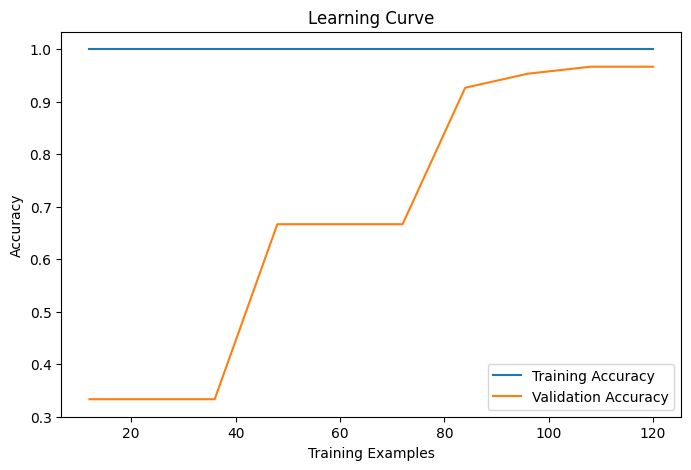

In [12]:
train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Accuracy')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [14]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print("XGBoost Accuracy:", xgb.score(X_test, y_test))

XGBoost Accuracy: 1.0


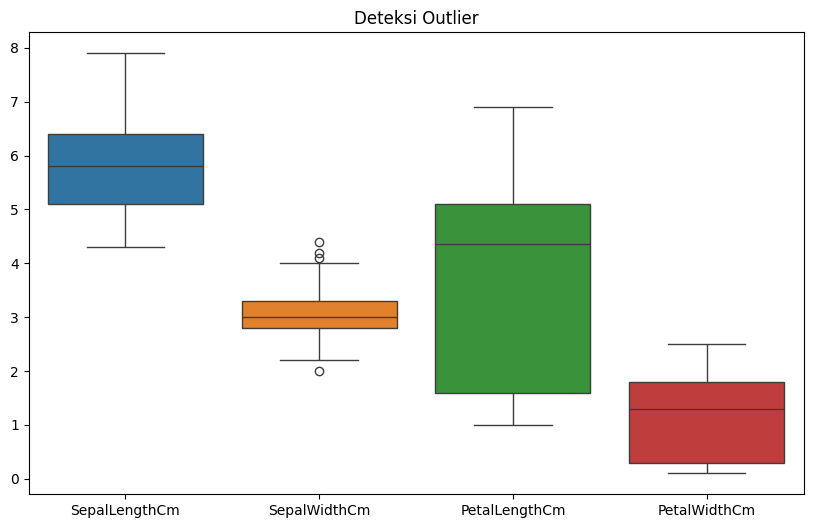

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=iris.drop('Species', axis=1))
plt.title('Deteksi Outlier')
plt.show()

In [17]:
!pip install streamlit
import streamlit as st
st.title('Iris Species Predictor')
sl = st.slider('Sepal Length', 4.0, 8.0, 5.1)
sw = st.slider('Sepal Width', 2.0, 4.5, 3.5)
pl = st.slider('Petal Length', 1.0, 7.0, 1.4)
pw = st.slider('Petal Width', 0.1, 2.5, 0.2)
if st.button('Predict'):
    pred = predict_species(sl, sw, pl, pw)
    st.success(f"Predicted Species: {pred}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


2025-05-25 14:54:01.251 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 14:54:01.369 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-25 14:54:01.370 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 14:54:01.371 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 14:54:01.373 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 14:54:01.373 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 14:54:01.375 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-25 14:54:01.376 Thread 'MainThread': mi

In [18]:
!pip install pyngrok

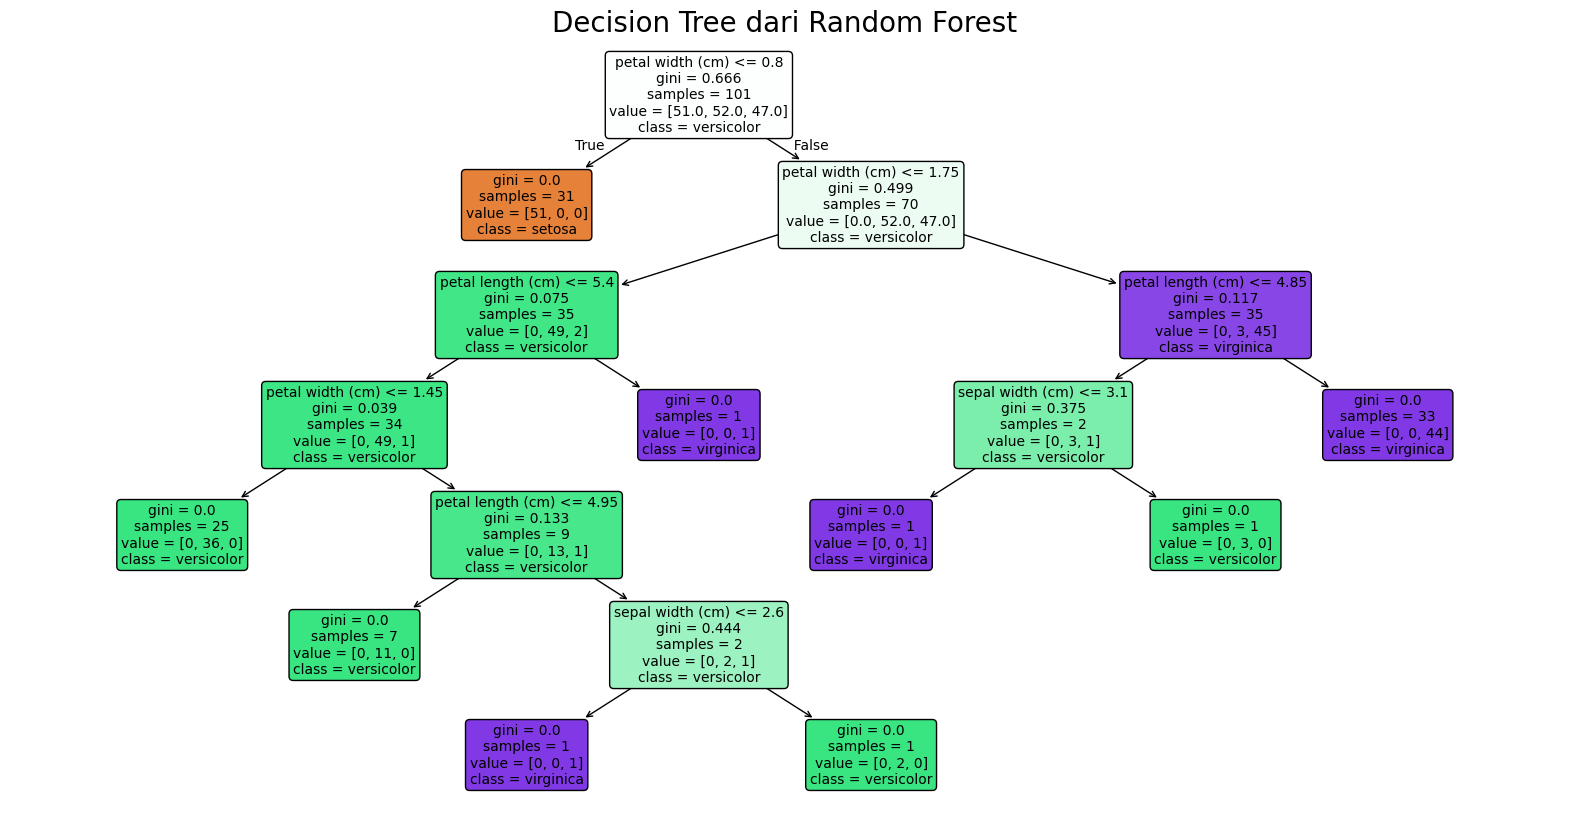

In [22]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

# Load dataset iris
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names

# Membuat dan melatih model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Visualisasi salah satu pohon keputusan dari Random Forest
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[0],
          feature_names=feature_names,
          class_names=iris.target_names,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree dari Random Forest", fontsize=20)
plt.show()